<div style="line-height:0.5">
<h1 style="color:#214fa2"> Feature selection 2 </h1>
</div>
<div style="line-height:1.5">
<div style="margin-top: -8px;">
<span style="display: inline-block;">
    <h3 style="color: lightblue; display: inline;">Keywords:</h3> pandas split + SelectKBest + RFE + numpy arctan
</span>
</div>
</div>

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, chi2, SelectKBest, RFE
from sklearn.model_selection import train_test_split, cross_val_score

from feature_engine.selection import SelectBySingleFeaturePerformance

<h2 style="color:#214fa2"> <u> Example #1 </u></h2>

In [95]:
# Toy dataset with redundant and constant features
X, y = datasets.make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=10)

In [ ]:
X = pd.DataFrame(X)

# Add constant features
X[[0, 5, 9]] = 1

In [93]:
# Remove constant features
sel = VarianceThreshold(threshold=0)

In [97]:
# Find the features with zero variance
X_t = sel.fit_transform(X)  
X_t

array([[-0.37653943, -0.62017967, -0.15756653, ..., -1.57457766,
         1.67804613,  1.0801799 ],
       [ 0.76240872, -0.78421   , -0.09647917, ...,  0.21094182,
        -0.85044853, -0.46130068],
       [ 2.22793382,  0.5477266 , -0.34148068, ..., -2.66367818,
         2.44004248,  1.69891857],
       ...,
       [ 0.74310266,  1.13675653, -0.10334924, ..., -2.12561551,
         2.8471565 , -0.91145218],
       [-1.43323743, -2.54920034,  0.13401841, ...,  0.1972835 ,
         0.39777869, -0.71639987],
       [ 0.73011191, -1.87888552,  0.50148994, ...,  1.20559488,
         0.74154153,  0.30886522]])

<h2 style="color:#214fa2"> <u> Example #2 </u></h2>
Variance thresholding (VT)

In [2]:
""" VT is the most basic approaches to feature selection. 
Idea motivated considering that features with low variance are likely less interesting (and useful) than features with high variance.
"""
iris = datasets.load_iris()
features = iris.data
target = iris.target

thresholder = VarianceThreshold(threshold=.5)  

# Create the high variance feature matrix
features_high_variance = thresholder.fit_transform(features) 
features_high_variance[0:3]

array([[5.1, 1.4, 0.2],
       [4.9, 1.4, 0.2],
       [4.7, 1.3, 0.2]])

<h2 style="color:#214fa2"> <u> Example #3 </u></h2>

In [3]:
dataset_kobe = pd.read_csv('./datasets_used/kobe_dataset.csv')

In [4]:
columns = dataset_kobe.columns
columns

Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id'],
      dtype='object')

Text(0.5, 1.0, 'loc_x and loc_y')

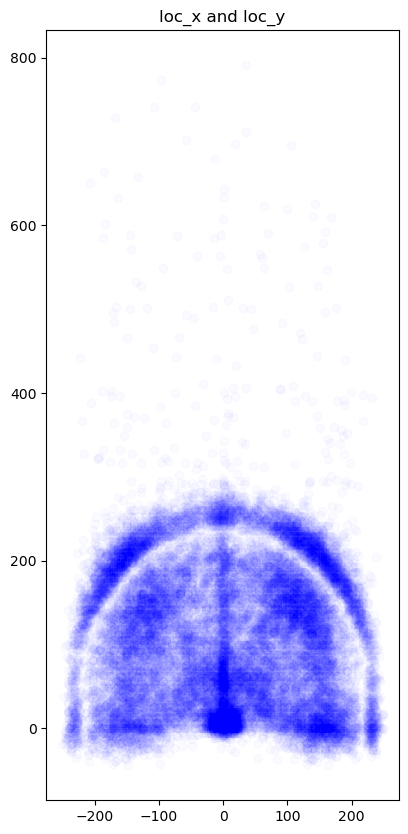

In [12]:
alpha = 0.02
plt.figure(figsize=(10,10))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122) 
# Explicitly call ax.remove() since Auto-removal of overlapping axes is deprecated!
ax1.remove()  
plt.scatter(dataset_kobe.loc_x, dataset_kobe.loc_y, color='blue', alpha=alpha)
plt.title('loc_x and loc_y')

/tmp/ipykernel_984658/2926099213.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)


<Figure size 1000x1000 with 0 Axes>

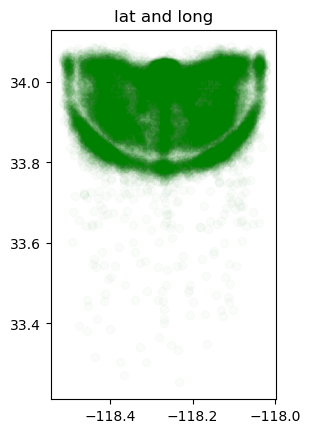

In [13]:
alpha = 0.02
plt.figure(figsize=(10,10))
plt.subplots(121)
plt.scatter(dataset_kobe.loc_x, dataset_kobe.loc_y, color='blue', alpha=alpha)
plt.title('loc_x and loc_y')
plt.subplot(122)
plt.scatter(dataset_kobe.lon, dataset_kobe.lat, color='green', alpha=alpha)
plt.title('lat and long');

In [15]:
# Add new column 'dist'
dataset_kobe['dist'] = np.sqrt(dataset_kobe['loc_x']**2 + dataset_kobe['loc_y']**2) 

loc_x_zero = dataset_kobe['loc_x'] == 0

In [14]:
"""" 
N.B. 
Add 'angle' column to avoid "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame"
Don't do chained indexing/assignment on DataFrame slices => (e.g. => dataset['angle'][~loc_x_zero])
But: 
Create a separate array called 'angle'. Then assign values to it, and then assign it back to the DataFrame column.
"""
angle = np.array([0]*len(dataset_kobe))
angle[~loc_x_zero] = np.arctan(dataset_kobe['loc_y'][~loc_x_zero] / dataset_kobe['loc_x'][~loc_x_zero]) 
angle[loc_x_zero] = np.pi/2

dataset_kobe['angle'] = angle

<h2 style="color:#214fa2"> <u> Example #4 </u></h2>

In [9]:
dataset_phones = pd.read_csv('./datasets_used/mobile_phone.csv')
dataset_phones.tail()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
2995,999,0,1.7,0.0,6,0,49,0.6,132.0,1,...,608,1970,1598,7,0,8,0,1,0,1
2996,999,0,2.6,1.0,11,1,56,1.0,165.0,4,...,342,1641,3083,8,4,11,1,1,1,2
2997,999,0,2.9,1.0,11,1,64,0.2,199.0,4,...,1397,1616,2593,14,11,16,1,1,0,2
2998,999,1,1.8,1.0,0,1,27,0.1,167.0,4,...,20,745,1344,17,10,5,1,0,0,0
2999,999,1533,1.0,0.5,1,0,0,50.0,0.4,171,...,12,38,832,2509,15,11,6,0,1,0


In [22]:
""" Sort """
dataset_phones.sort_values('price_range', inplace=True)
dataset_phones.tail()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
184,1128,1,1.4,0.0,12,0,53,0.4,84.0,5,...,609,1370,2982,14,9,12,1,1,0,3
682,1488,0,0.5,0.0,1,0,39,0.8,112.0,5,...,1528,1647,3054,14,10,19,0,0,0,3
1319,1938,1,0.5,1.0,5,0,44,0.5,121.0,2,...,1299,1935,3497,18,10,18,0,1,0,3
1331,1946,0,2.7,1.0,8,0,8,0.3,123.0,8,...,647,1849,3117,6,0,2,1,0,0,3
778,1554,1,0.5,1.0,11,0,5,1.0,124.0,3,...,395,1579,3635,7,4,18,0,0,0,3


In [24]:
""" Split data without sklearn """
phone_train = dataset_phones.sample(frac=0.8, random_state=8) 
phone_test = dataset_phones.drop(phone_train.index)

In [27]:
print("Phone train is:")
type(phone_train), phone_train.shape

Phone train


(pandas.core.frame.DataFrame, (2400, 21))

In [28]:
print("Phone test is:")
type(phone_test), phone_test.shape

Phone test


(pandas.core.frame.DataFrame, (600, 21))

In [30]:
#### Split 
X_train = phone_train.iloc[:, 0:20]
y_train = phone_train.iloc[:, -1]

X_test = phone_test.iloc[:, 0:20]
y_test = phone_test.iloc[:, -1]

X_train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
2912,962,623,1.0,0.5,1,5,1,29.0,0.9,134,3,10,273,1814,717,12,5,13,1,0
1275,1900,1,2.3,0.0,1,1,18,0.2,89.0,7,9,1055,1661,2871,12,1,13,1,1,1
2793,912,1,2.0,0.0,1,0,54,0.3,161.0,8,5,329,1053,2330,19,5,20,0,1,0
205,1142,1,1.1,0.0,0,1,6,0.5,198.0,4,0,739,1766,1273,19,0,6,1,0,0
605,1432,1,1.7,1.0,6,1,39,0.3,164.0,4,18,209,947,504,14,4,10,1,1,0


In [35]:
# Apply SelectKBest => Select features according to the k=10 highest scores.
best_features = SelectKBest(score_func=chi2, k =10)

In [38]:
fit_best = best_features.fit(X_train, y_train);

In [39]:
fit_best.scores_

array([1.28700125e+05, 4.97185199e+05, 1.20728906e+02, 1.61726457e+02,
       7.48990977e+02, 1.22650447e+03, 6.92416569e+03, 1.27706350e+04,
       2.88106446e+04, 4.92159026e+04, 6.14930824e+02, 1.82361756e+05,
       7.82203139e+04, 1.02945023e+06, 8.43169802e+05, 6.26870921e+02,
       4.65741745e+02, 3.43694526e+03, 2.46622847e+01, 7.08244526e-01])

In [41]:
dataframe_scores = pd.DataFrame(fit_best.scores_)
dataframe_scores

,0
0,1.287001e+05
1,4.971852e+05
2,1.207289e+02
3,1.617265e+02
4,7.489910e+02
5,1.226504e+03
6,6.924166e+03
7,1.277064e+04
8,2.881064e+04
9,4.921590e+04


In [42]:
dataframe_columns = pd.DataFrame(X_train.columns)
dataframe_columns

,0
0,battery_power
1,blue
2,clock_speed
3,dual_sim
4,fc
5,four_g
6,int_memory
7,m_dep
8,mobile_wt
9,n_cores


In [46]:
feature_scores = pd.concat([dataframe_columns, dataframe_scores], axis= 1)
feature_scores

,0,0
0,battery_power,1.287001e+05
1,blue,4.971852e+05
2,clock_speed,1.207289e+02
3,dual_sim,1.617265e+02
4,fc,7.489910e+02
5,four_g,1.226504e+03
6,int_memory,6.924166e+03
7,m_dep,1.277064e+04
8,mobile_wt,2.881064e+04
9,n_cores,4.921590e+04


In [50]:
feature_scores.columns = ['Features', 'Score']

In [51]:
# Table of scores
feature_scores

,Features,Score
0,battery_power,1.287001e+05
1,blue,4.971852e+05
2,clock_speed,1.207289e+02
3,dual_sim,1.617265e+02
4,fc,7.489910e+02
5,four_g,1.226504e+03
6,int_memory,6.924166e+03
7,m_dep,1.277064e+04
8,mobile_wt,2.881064e+04
9,n_cores,4.921590e+04


In [52]:
feature_scores.sort_values(by='Score', ascending= False)


,Features,Score
13,ram,1.029450e+06
14,sc_h,8.431698e+05
1,blue,4.971852e+05
11,px_height,1.823618e+05
0,battery_power,1.287001e+05
12,px_width,7.822031e+04
9,n_cores,4.921590e+04
8,mobile_wt,2.881064e+04
7,m_dep,1.277064e+04
6,int_memory,6.924166e+03


In [55]:
ten_features = feature_scores.sort_values(by='Score', ascending= False).head(10)['Features'].values
ten_features

array(['ram', 'sc_h', 'blue', 'px_height', 'battery_power', 'px_width',
       'n_cores', 'mobile_wt', 'm_dep', 'int_memory'], dtype=object)

<h3 style="color:#214fa2"> => Feature importance 1: </h3>

In [61]:
forest_model = RandomForestClassifier()
forest_model.fit(X_train, y_train);

In [63]:
forest_model.feature_importances_

array([0.07423446, 0.03096569, 0.02255516, 0.01709573, 0.01815555,
       0.01660456, 0.03722736, 0.0339237 , 0.04477345, 0.03914362,
       0.02768275, 0.05315585, 0.05548933, 0.3777111 , 0.05006365,
       0.02913987, 0.03180846, 0.02663493, 0.00646291, 0.00717185])

In [65]:
feature_Importance =  pd.DataFrame(forest_model.feature_importances_, index=X_train.columns, columns=['Importance'])
feature_Importance = feature_Importance.sort_values(by="Importance", ascending= False)

feature_Importance

,Importance
ram,0.377711
battery_power,0.074234
px_width,0.055489
px_height,0.053156
sc_h,0.050064
mobile_wt,0.044773
n_cores,0.039144
int_memory,0.037227
m_dep,0.033924
talk_time,0.031808


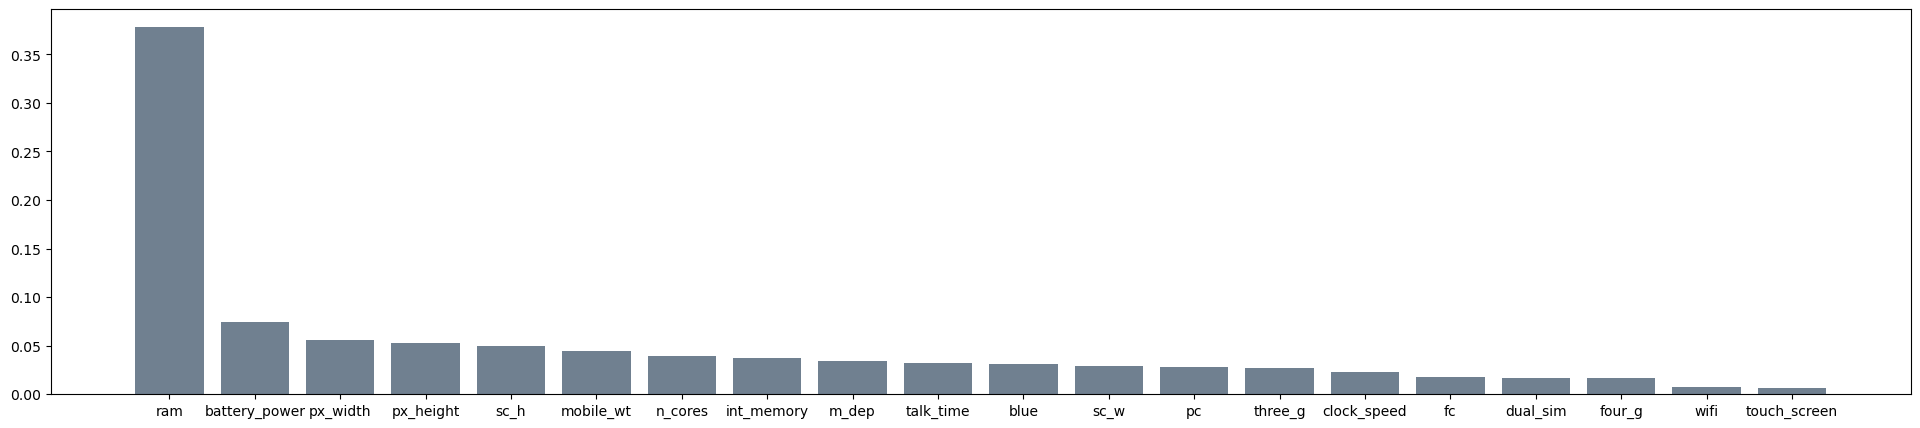

In [73]:
plt.figure(figsize=(24,5))
plt.bar(feature_Importance.index, feature_Importance['Importance'], color='slategray')
plt.show()

In [77]:
# Calculate correlation between features 
data_corr = dataset_phones.corr()
data_corr.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
battery_power,1.000000,-0.610675,0.367343,-0.411723,0.316844,-0.385896,0.466206,-0.550970,0.605323,-0.630797,...,0.428544,0.364065,0.271000,-0.567093,-0.381582,0.336369,-0.546508,-0.158038,0.006986,0.404035
blue,-0.610675,1.000000,-0.509638,0.553858,-0.415284,0.543268,-0.652537,0.765763,-0.843055,0.871926,...,-0.586395,-0.509063,-0.374383,0.773497,0.505237,-0.433627,0.773133,0.229224,-0.008373,-0.404393
clock_speed,0.367343,-0.509638,1.000000,-0.328114,0.245171,-0.343266,0.391157,-0.456971,0.504765,-0.519157,...,0.339797,0.293611,0.225216,-0.453498,-0.308179,0.249096,-0.465368,-0.117668,-0.023269,0.238230
dual_sim,-0.411723,0.553858,-0.328114,1.000000,-0.288597,0.367588,-0.439250,0.497835,-0.561897,0.580020,...,-0.397636,-0.334290,-0.223071,0.518096,0.325403,-0.308078,0.485138,0.134383,0.027007,-0.268883
fc,0.316844,-0.415284,0.245171,-0.288597,1.000000,-0.264821,0.300036,-0.373779,0.419829,-0.428542,...,0.279340,0.249953,0.197304,-0.378888,-0.258840,0.204882,-0.375379,-0.119750,0.018991,0.214713


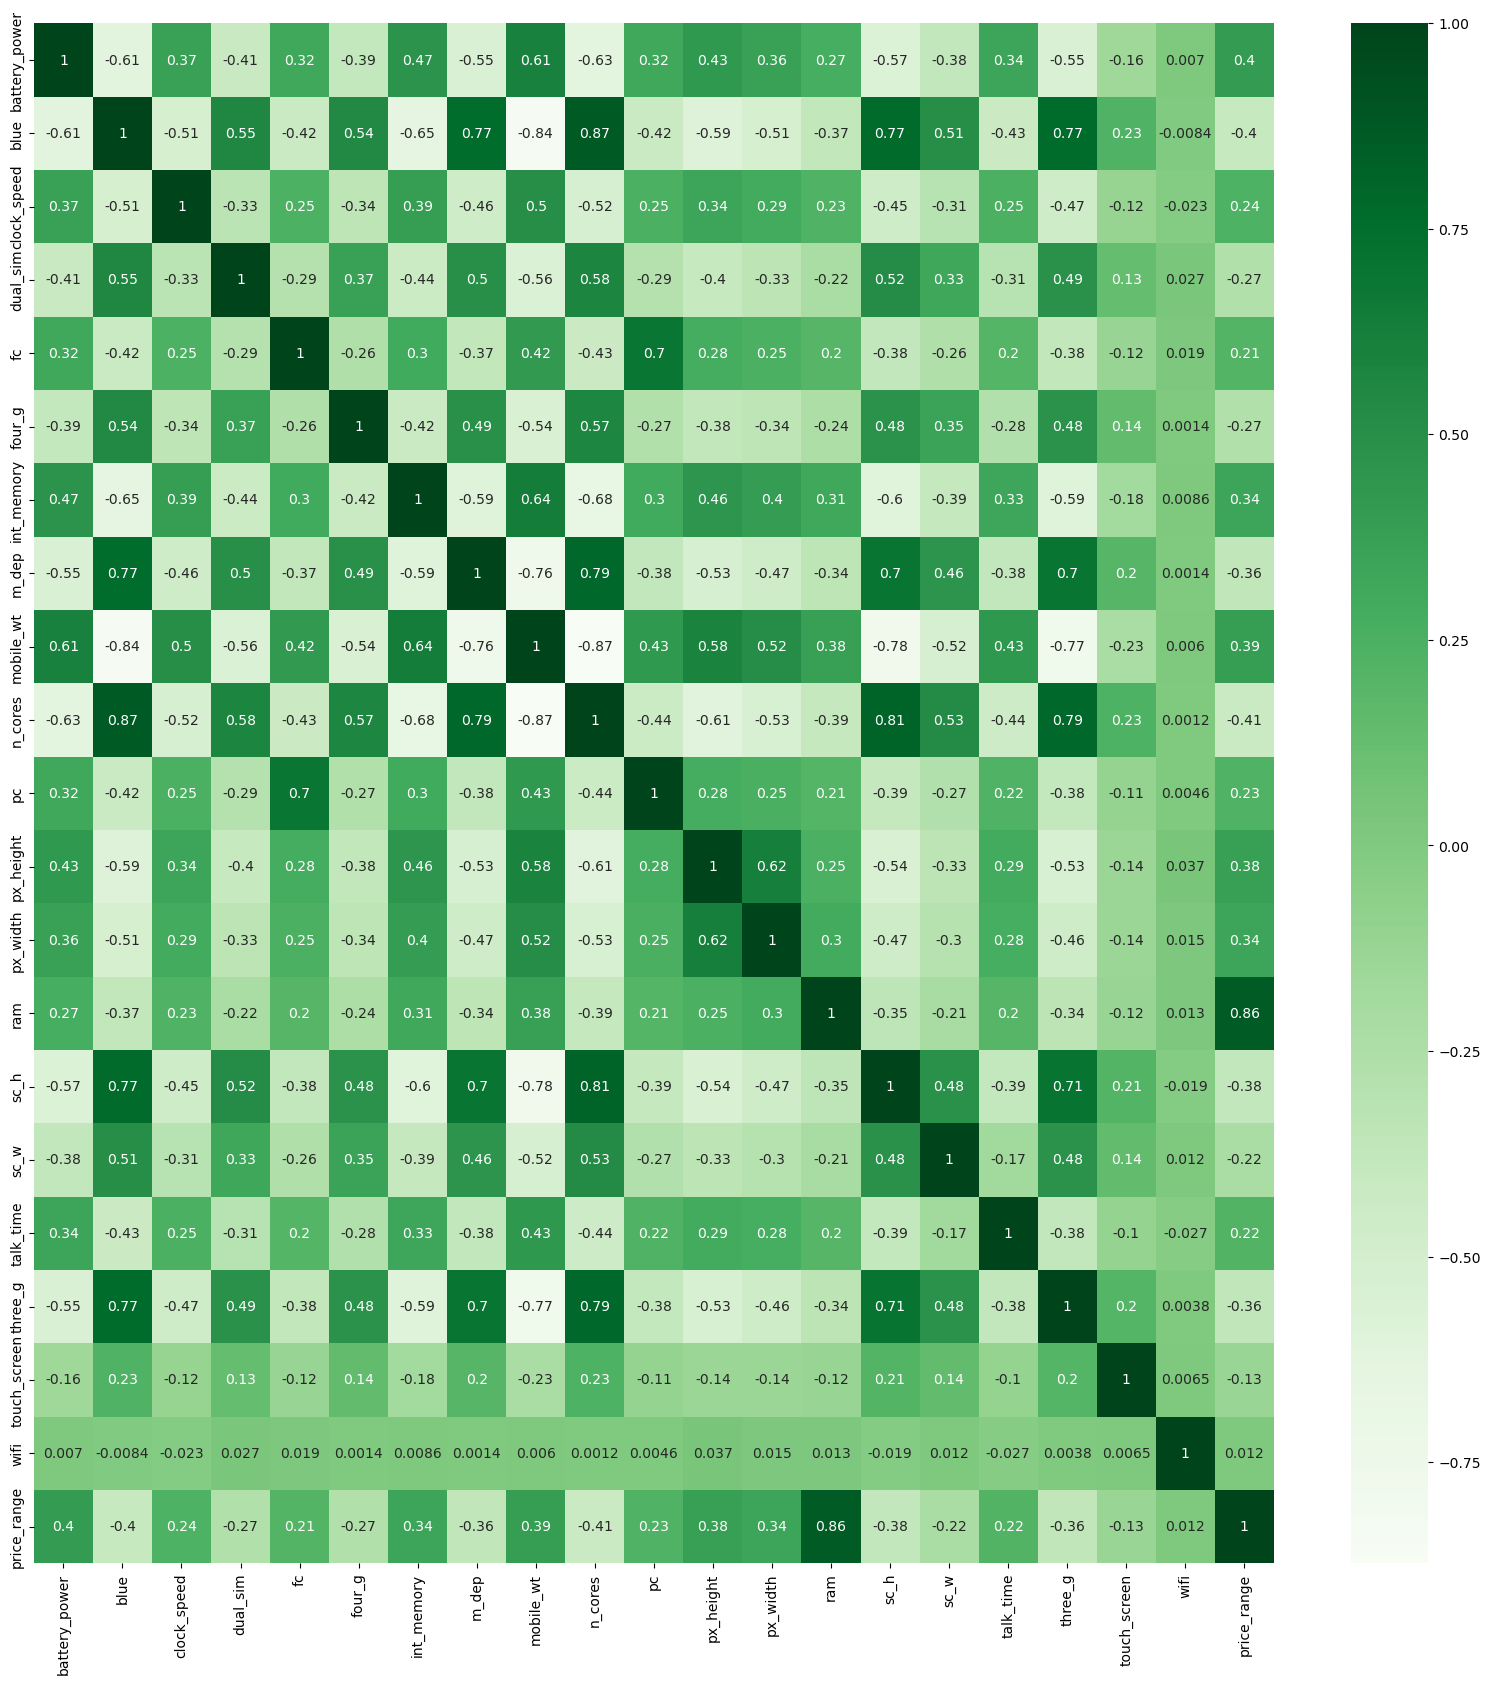

In [78]:
plt.figure(figsize=(20,20))
sns.heatmap(data_corr, annot=True, cmap='Greens')
plt.show()

<h3 style="color:#214fa2"> => Feature importance 2 </h3>

In [81]:
rfc = RandomForestClassifier(max_depth=10)

In [83]:
scores = cross_val_score(rfc, X_train, y_train, cv = 10)

In [84]:
scores.mean()


0.7354166666666667

In [86]:
X_train[ten_features]


,ram,sc_h,blue,px_height,battery_power,px_width,n_cores,mobile_wt,m_dep,int_memory
2912,1814,717,623,10,962,273,134,0.9,29.0,1
1275,2871,12,1,1055,1900,1661,7,89.0,0.2,18
2793,2330,19,1,329,912,1053,8,161.0,0.3,54
205,1273,19,1,739,1142,1766,4,198.0,0.5,6
605,504,14,1,209,1432,947,4,164.0,0.3,39
...,...,...,...,...,...,...,...,...,...,...
1338,832,7,1,837,1949,1182,5,145.0,0.1,31
2695,1212,2819,1060,11,871,582,162,0.6,31.0,1
786,1783,13,0,885,1561,1811,2,134.0,0.5,4
2401,1541,2338,1427,12,757,249,121,0.8,40.0,1


In [90]:
scores_new = cross_val_score(rfc, X_train[ten_features], y_train, cv = 10)
scores_new

array([0.725     , 0.77916667, 0.78333333, 0.79583333, 0.75416667,
       0.77083333, 0.77916667, 0.76666667, 0.80833333, 0.74583333])

In [91]:
scores_new.mean()

0.7708333333333334

<h2 style="color:#214fa2"> <u> Example #5 </u></h2>
Recursive Feature Elimination RFE

<h4 style="color:#214fa2"> Recap: Recursive feature elimination RFE </h4>    
<div style="margin-top: -10px;">
Sequential process => Remove features at each iteration, assess the importance of the features after each elimination.  Repeat again
</div>

In [3]:
# Load dataset
breast_cancer = load_breast_cancer()
X_cancer = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
y_cancer = breast_cancer.target

In [4]:
# Separate data into train and test sets
X_train_canc, X_test_canc, y_train_canc, y_test_canc = train_test_split(X_cancer, y_cancer, random_state=0)

In [5]:
# Create model
classifier = RandomForestClassifier(n_estimators=10, random_state=10)

In [6]:
sel_ = RFE(classifier, n_features_to_select=8, step=2,) #steps = number of features to remove at each iteration

In [7]:
sel_.fit(X_train_canc, y_train_canc)

X_train_canc_selected = sel_.transform(X_train_canc)
X_test_canc_selected = sel_.transform(X_test_canc)

<h2 style="color:#214fa2"> <u> Example #6 </u></h2>
Features importance 

<h4 style="color:#214fa2"> Recap: Univariate feature selection </h4>    
<div style="margin-top: -10px;">
Select the most useful features in a dataset, independently to determine how useful it is at predicting the target variable. <br>
Id does not consider the interactions or the correlations between features. 

In [9]:
# load dataset
breast_cancer = datasets.load_breast_cancer()
X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
y = breast_cancer.target

In [10]:
# Separate data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [15]:
sel = SelectBySingleFeaturePerformance(estimator=RandomForestClassifier(random_state=10), scoring='roc_auc', cv=3, threshold=None,)

In [16]:
X_train_t = sel.fit_transform(X_train, y_train)
X_test_t = sel.transform(X_test)

Text(0.5, 1.0, 'Univariate performance')

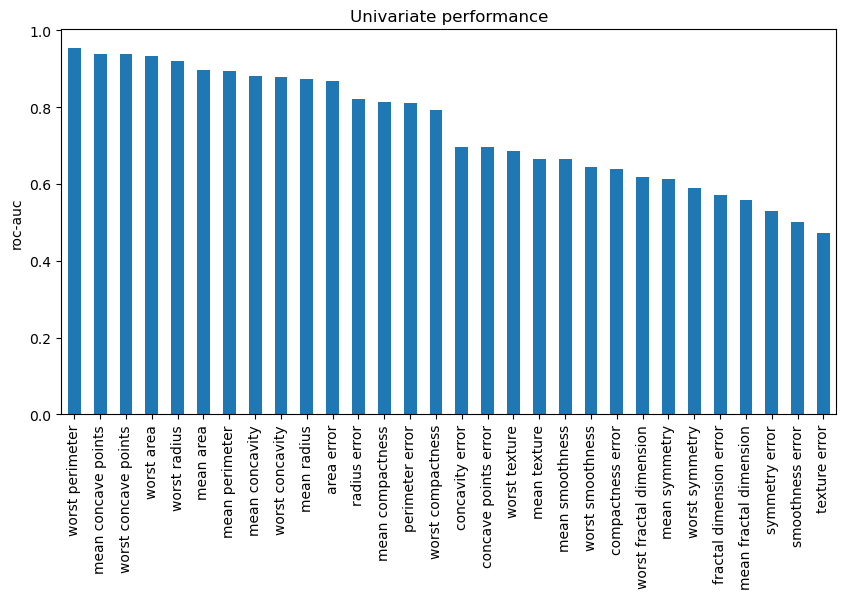

In [17]:
# Visualize the importance of the features 
pd.Series(sel.feature_performance_).sort_values(ascending=False).plot.bar(figsize=(10, 5))
plt.ylabel('roc-auc')
plt.title('Univariate performance')

<h3 style="color:#214fa2"> => Considering correlations  </h3>    

In [21]:
# Toy dataset with correlated features

X, y = datasets.make_classification(n_samples=1000, n_features=10, n_redundant=7, n_classes=2, random_state=10,)
X_toy = pd.DataFrame(X)

In [22]:
# the default correlation method of pandas.corr is pearson
corrmat = X_toy.corr(method='pearson')

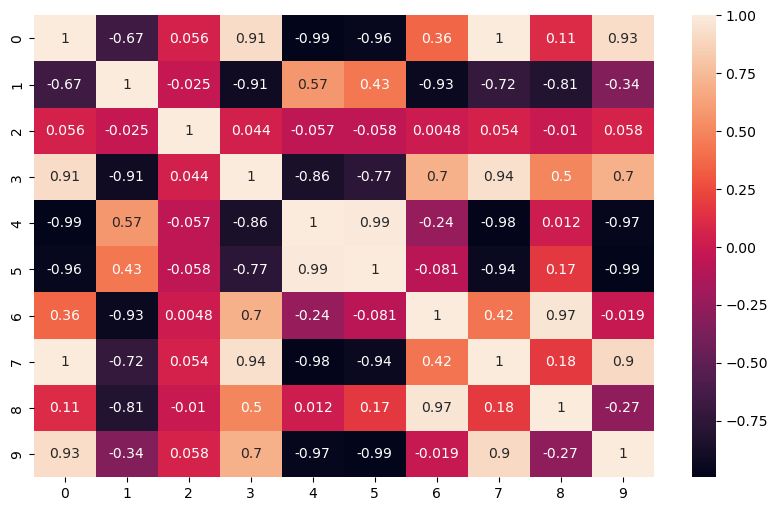

In [25]:
# we can make a heatmap with seaborn
plt.figure(figsize=(10, 6)) 
sns.heatmap(corrmat, annot=True)
plt.show()